# Loading the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PROJECT_PATH = '/content/drive/My Drive/Datasets/ML Project'
DATASETS_PATH = f'{PROJECT_PATH}/data/recommended'
TRAINING_PATH = f'{DATASETS_PATH}/training/training_cleaned.csv'
FIGURES_PATH = f'{PROJECT_PATH}/figures/eda'
INDEX_COL = 'pkSeqID'

In [3]:
import pandas as pd

training = pd.read_csv(TRAINING_PATH, index_col=INDEX_COL)
training.head()

,min,max,mean,stddev,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,drate,srate,sport,dport,proto,state_number,category
pkSeqID,,,,,,,,,,,,,
3142762,0.000000,4.031619,2.687519,1.900363,100,100,0.0,0.494549,6551,80,udp,4,DDoS UDP
2432264,3.856930,4.012924,3.934927,0.078003,38,100,0.0,0.256493,5532,80,tcp,3,DDoS TCP
1976315,2.974100,3.609205,3.341429,0.268666,100,100,0.0,0.294880,27165,80,tcp,3,DDoS TCP
1240757,0.000000,4.942302,3.222832,1.823185,63,63,0.0,0.461435,48719,80,udp,4,DoS UDP
3257991,2.979995,4.994452,3.983222,0.822418,100,100,0.0,1.002999,22461,80,udp,4,DDoS UDP


In [27]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2934817 entries, 3142762 to 96906
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   min                float64
 1   max                float64
 2   mean               float64
 3   stddev             float64
 4   N_IN_Conn_P_SrcIP  int64  
 5   N_IN_Conn_P_DstIP  int64  
 6   drate              float64
 7   srate              float64
 8   sport              int64  
 9   dport              int64  
 10  proto              object 
 11  state_number       int64  
 12  category           object 
dtypes: float64(6), int64(5), object(2)
memory usage: 313.5+ MB


## Imports

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

# Number of inbound connections per IP address

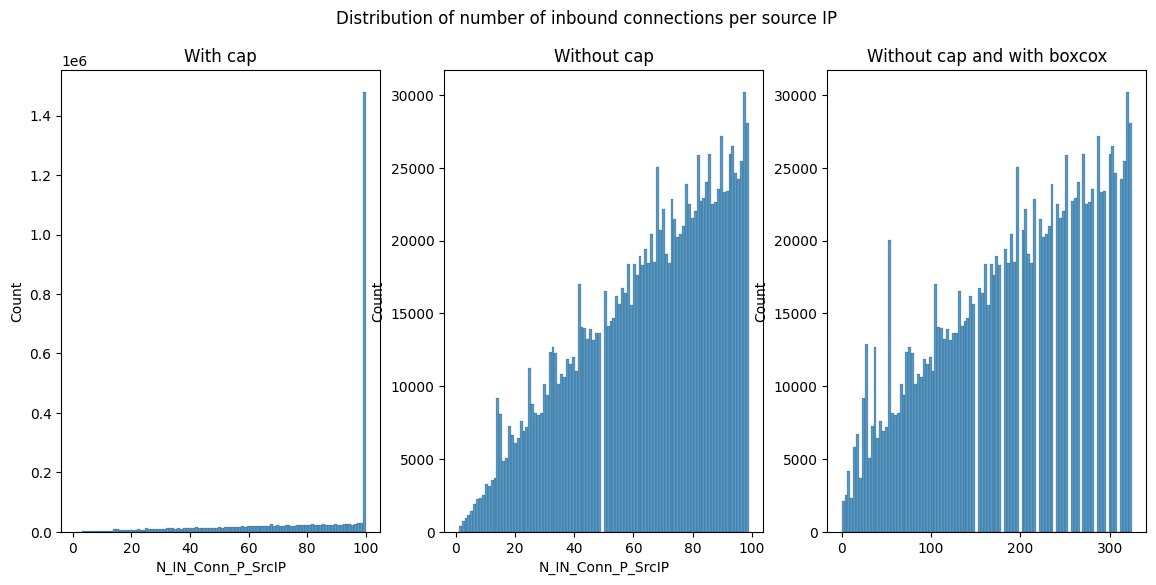

In [31]:
fig, axes = plt.subplots(1, 3)

sns.histplot(
    x=training['N_IN_Conn_P_SrcIP'],
    bins=100,
    ax=axes[0],
)

sns.histplot(
    x=training.loc[training['N_IN_Conn_P_SrcIP'] < 100, 'N_IN_Conn_P_SrcIP'],
    bins=100,
    ax=axes[1]
)

x, _ = boxcox(training.loc[training['N_IN_Conn_P_SrcIP'] < 100, 'N_IN_Conn_P_SrcIP'])
sns.histplot(
    x=x,
    bins=100,
    ax=axes[2]
)

axes[0].set_title('With cap')
axes[1].set_title('Without cap')
axes[2].set_title('Without cap and with boxcox')

fig.suptitle('Distribution of number of inbound connections per source IP')

fig.set_size_inches(14, 6)
plt.savefig(f'{FIGURES_PATH}/n_inbound_conn_per_src_ip.png')


Clearly a cap is set at the value of 100, and since most of the traffic is for ddos/dos attacks, it is most common value

Outside of that the distribution of traffic is linear

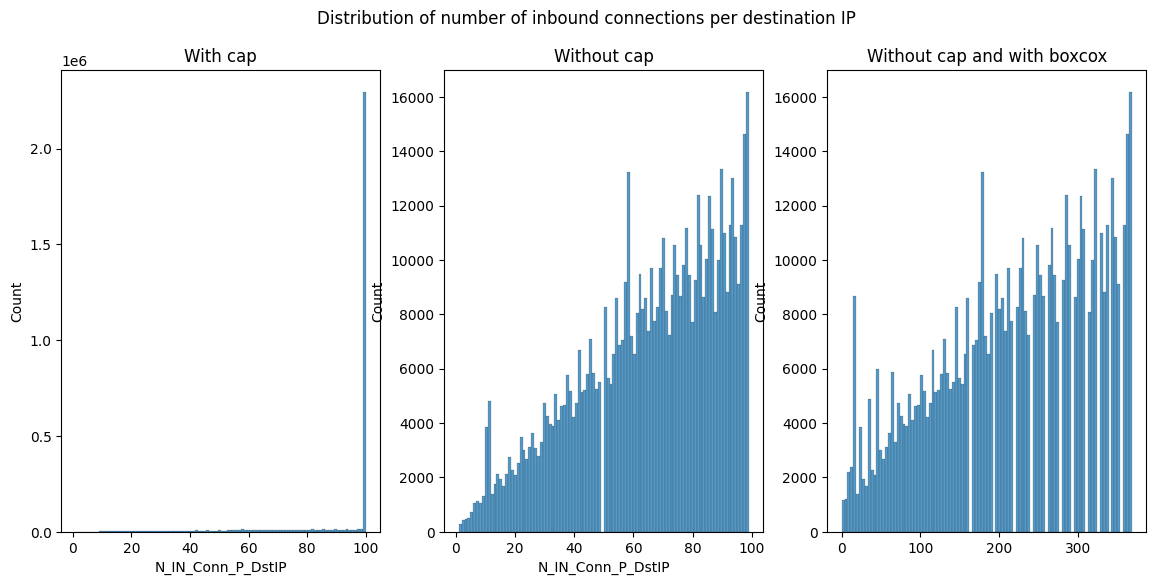

In [30]:
fig, axes = plt.subplots(1, 3)

training.N_IN_Conn_P_DstIP
sns.histplot(
    x=training['N_IN_Conn_P_DstIP'],
    bins=100,
    ax=axes[0],
)

sns.histplot(
    x=training.loc[training['N_IN_Conn_P_DstIP'] < 100, 'N_IN_Conn_P_DstIP'],
    bins=100,
    ax=axes[1]
)

x, _ = boxcox(training.loc[training['N_IN_Conn_P_DstIP'] < 100, 'N_IN_Conn_P_DstIP'])
sns.histplot(
    x=x,
    bins=100,
    ax=axes[2]
)

axes[0].set_title('With cap')
axes[1].set_title('Without cap')
axes[2].set_title('Without cap and with boxcox')

fig.suptitle('Distribution of number of inbound connections per destination IP')

fig.set_size_inches(14, 6)
plt.savefig(f'{FIGURES_PATH}/n_inbound_conn_per_src_ip.png')


/tmp/ipython-input-3526175921.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{FIGURES_PATH}/Scatter plot of inbound connection per src ip with respect to dst ip.png')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


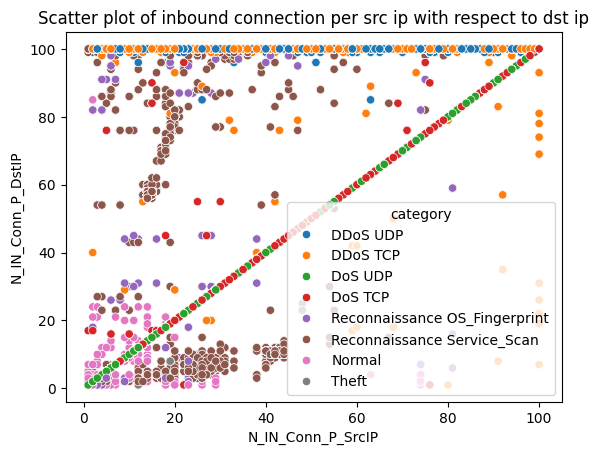

In [37]:
sns.scatterplot(x='N_IN_Conn_P_SrcIP', y='N_IN_Conn_P_DstIP', hue='category', data=training)
plt.title('Scatter plot of inbound connection per src ip with respect to dst ip')
plt.savefig(f'{FIGURES_PATH}/Scatter plot of inbound connection per src ip with respect to dst ip.png')

We can recognize some patterns as per attack type:
- **DDoS Attacks:** Tend to have a high number of inbound traffic destined to the same IP address, without much relation to the source IP (suggesting some machines sent huge traffic compared to others), which is expected since the attack is distributed, the type of protocol (`udp` or `tcp`) is not relevant
- **DoS Attacks:** The number of inbound traffic per destination and source IP are correlated, since the attack is sent from a single machine to a specific target, again the protocol is irrelevant
- **Reconnaissonce OS fingerprint:** seem to have a weird pattern were either really high traffic per dst ip (meaning same target) with low traffic per src ip (meaning the rate of messages is very low); or somewhat low src traffic and low dst traffic
- **Normal Traffic:** as expected normal traffic has a low rate for both src IP and dst IP

In [8]:
sum(training['N_IN_Conn_P_DstIP'] > training['N_IN_Conn_P_SrcIP']) / sum(training['N_IN_Conn_P_SrcIP'] > training['N_IN_Conn_P_DstIP'])

97.69744850187266

This score means that generally inbound connections per dst ip tend to be higher than those per src ip, it would be more useful to us if we calculate the ratio of those per dst ip with respect to those per src ip to get higher values

In [14]:
eps = 0.0001
training['N_IN_Conn_P_DstIP_to_SrcIP'] = (training['N_IN_Conn_P_DstIP'] + eps) / (training['N_IN_Conn_P_SrcIP'] + eps)
training['N_IN_Conn_P_SrcIP_to_DstIP'] = (training['N_IN_Conn_P_SrcIP'] + eps) / (training['N_IN_Conn_P_DstIP'] + eps)

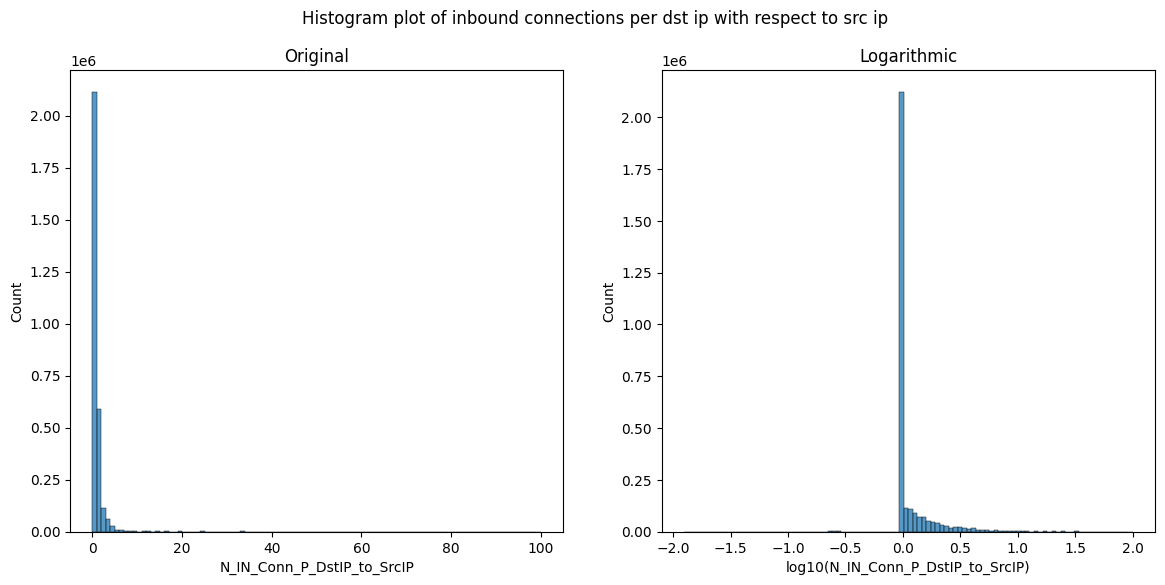

In [15]:
fig, axes = plt.subplots(1, 2)
title = 'Histogram plot of inbound connections per dst ip with respect to src ip'
fig.suptitle(title)
fig.set_size_inches(14, 6)
sns.histplot(data=training, x='N_IN_Conn_P_DstIP_to_SrcIP', bins=100, ax=axes[0])
axes[0].set_title('Original')
sns.histplot(np.log10(training['N_IN_Conn_P_DstIP_to_SrcIP']), bins=100, ax=axes[1])
axes[1].set_title('Logarithmic')
axes[1].set_xlabel('log10(N_IN_Conn_P_DstIP_to_SrcIP)')
plt.savefig(f'{FIGURES_PATH}/{title}.png')

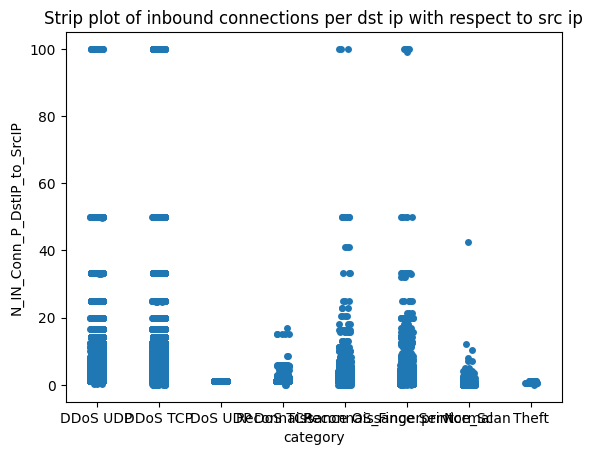

In [17]:
sns.stripplot(data=training, y='N_IN_Conn_P_DstIP_to_SrcIP', x='category')
title = 'Strip plot of inbound connections per dst ip with respect to src ip'
plt.title(title)
plt.savefig(f'{FIGURES_PATH}/{title}.png')

As we can see the ratio of inbound connections between those aggregated per dst ip and those per src ip is not very informative of the category so it is not very useful

65


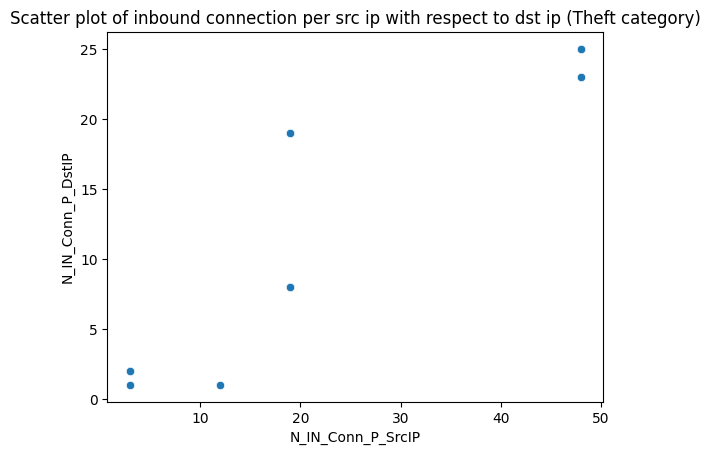

In [41]:
d = data=training.loc[training['category'] == 'Theft']
print(len(d))
sns.scatterplot(x='N_IN_Conn_P_SrcIP', y='N_IN_Conn_P_DstIP', data=d)
plt.title('Scatter plot of inbound connection per src ip with respect to dst ip (Theft category)')
plt.savefig(f'{FIGURES_PATH}/Scatter plot of inbound connection per src ip with respect to dst ip (Theft category).png')

**Theft** generally seems to follow a linear line, but no conclusions can be made

# Packet Rates

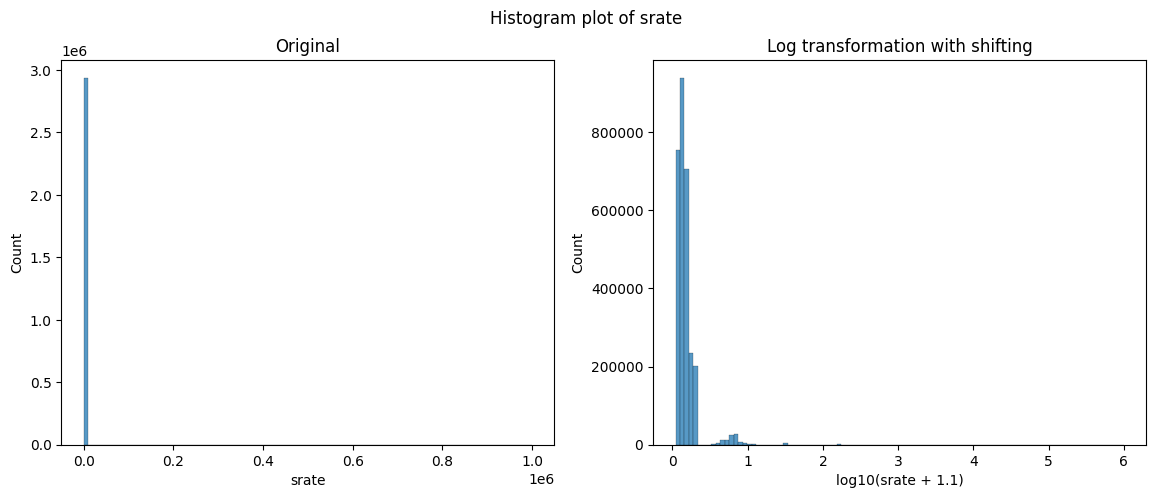

In [25]:
fig, axes = plt.subplots(1, 2)
sns.histplot(x=training.loc[:, 'srate'], bins=100, ax=axes[0])
axes[0].set_title('Original')

sns.histplot(x=np.log10(training['srate'] + 1.1), bins=100, ax=axes[1])
axes[1].set_title('Log transformation with shifting')
axes[1].set_xlabel('log10(srate + 1.1)')

fig.suptitle('Histogram plot of srate')
fig.set_size_inches(14, 5)
plt.savefig(f'{FIGURES_PATH}/distribution of srate.png')

As we can notice applying the log transformation makes the distribution a lot more normal, when it comes to `srate`(specific handling using by eliminating 0 is also done)

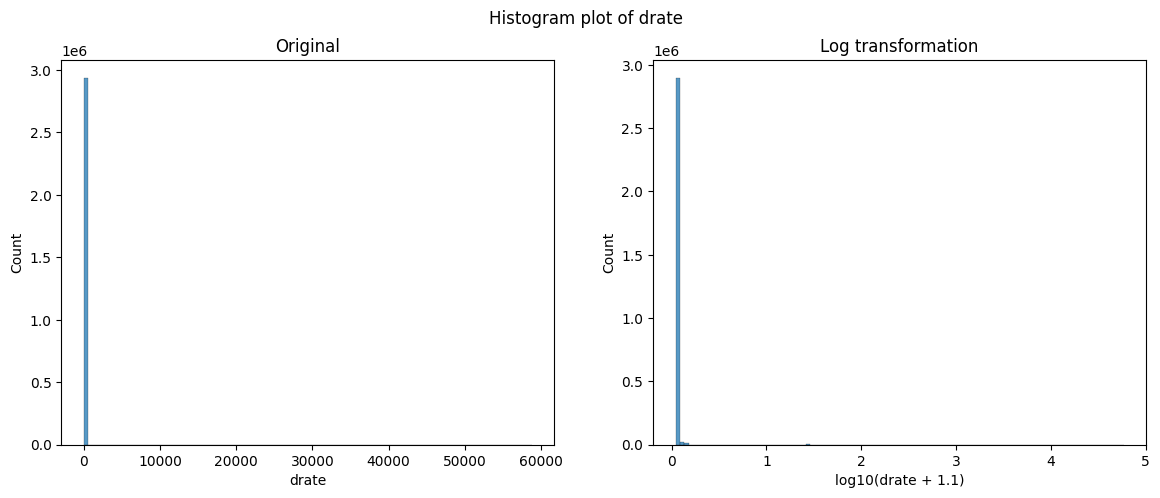

In [26]:
fig, axes = plt.subplots(1, 2)
sns.histplot(x=training.loc[:, 'drate'], bins=100, ax=axes[0])
axes[0].set_title('Original')

sns.histplot(x=np.log10(training.loc[:, 'drate'] + 1.1), bins=100, ax=axes[1])
axes[1].set_title('Log transformation')
axes[1].set_xlabel('log10(drate + 1.1)')

fig.suptitle('Histogram plot of drate')
fig.set_size_inches(14, 5)
plt.savefig(f'{FIGURES_PATH}/distribution of drate.png')

The logarithmic function with 1 added didn't perform so well in fixing the distributions, another solution is to assign the zero values a really low value, this is due to the fact that a high number of rates is close or equal to 0

In [19]:
training_chk1 = training.copy()
training['srate'] = np.log10(training['srate'] + 1.1)
training['drate'] = np.log10(training['drate'] + 1.1)

In [21]:
training['srate_to_drate'] = training['srate'] / training['drate']

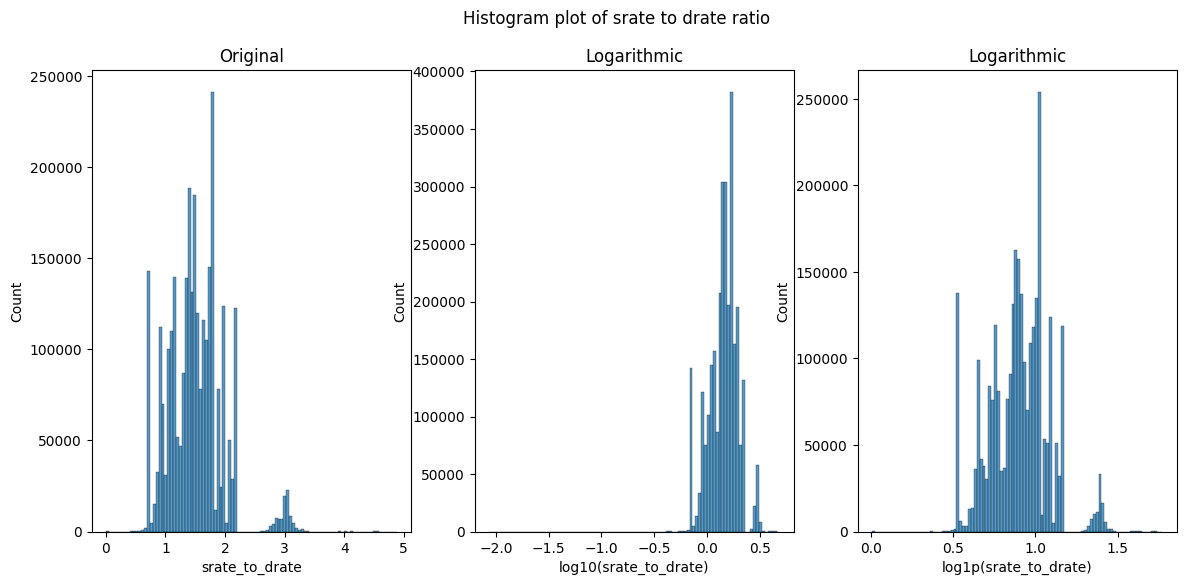

In [27]:
fig, axes = plt.subplots(1, 3)
title = 'Histogram plot of srate to drate ratio'
fig.suptitle(title)
fig.set_size_inches(14, 6)

sns.histplot(x=training['srate_to_drate'], bins=100, ax=axes[0])
axes[0].set_title('Original')

sns.histplot(x=np.log10(training['srate_to_drate']), bins=100, ax=axes[1])
axes[1].set_title('Logarithmic')
axes[1].set_xlabel('log10(srate_to_drate)')

sns.histplot(x=np.log1p(training['srate_to_drate']), bins=100, ax=axes[2])
axes[2].set_title('Logarithmic')
axes[2].set_xlabel('log1p(srate_to_drate)')

plt.savefig(f'{FIGURES_PATH}/{title}.png')

Applying the logarithm makes the distribution more normal

In [22]:
training_chk2 = training.copy()
training['srate_to_drate'] = np.log1p(training['srate_to_drate'])

/tmp/ipython-input-3903142128.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{FIGURES_PATH}/Scatter plot of log1p(srate + 1.1) to log1p(drate + 1.1).png')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


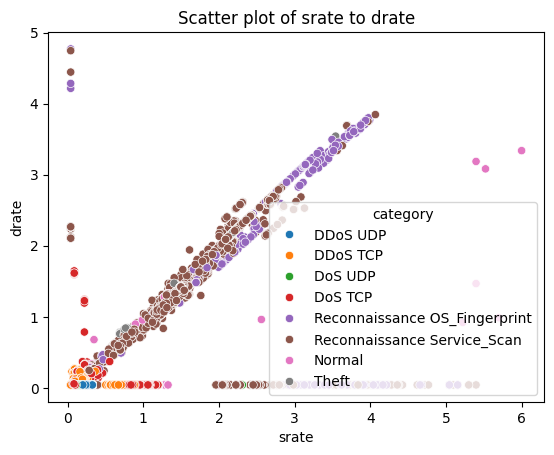

In [24]:
sns.scatterplot(data=training, hue='category', x='srate', y='drate')
plt.title('Scatter plot of srate to drate')
plt.savefig(f'{FIGURES_PATH}/Scatter plot of log10(srate + 1.1) to log10(drate + 1.1).png')

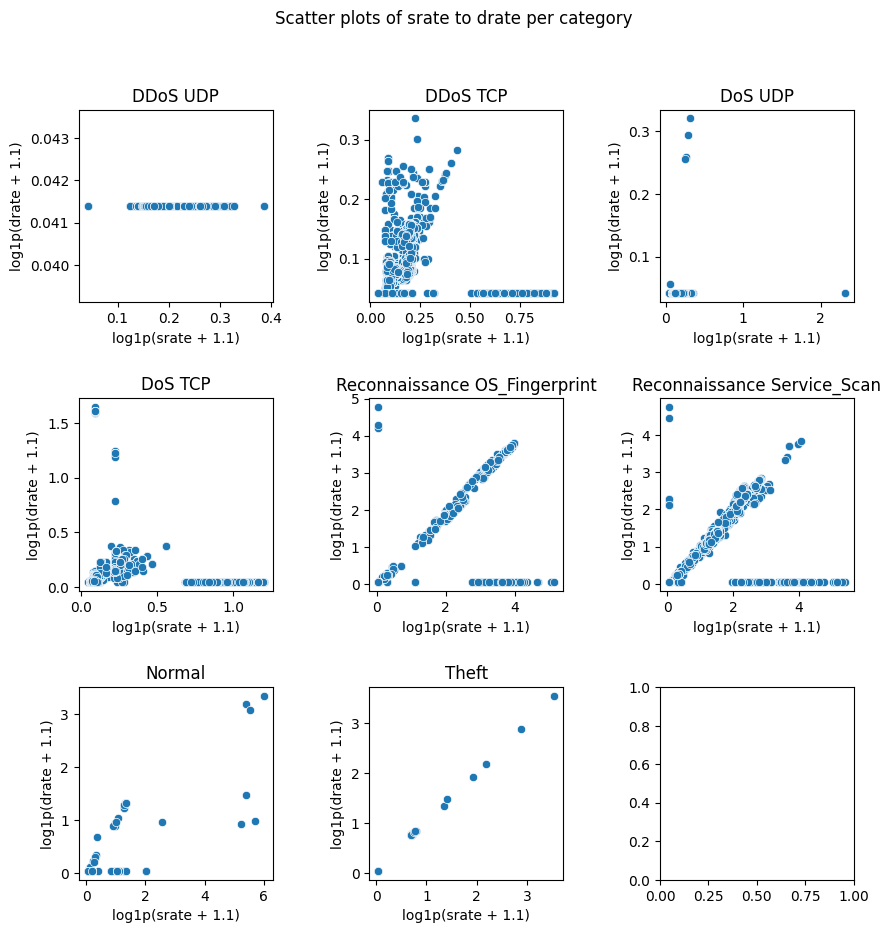

In [25]:
categories = training['category'].unique()
fig, axes = plt.subplots(3, 3)

for i in range(3):
  for j in range(3):
    if 3*i + j > 7:
      continue
    category = categories[3* i + j]
    axes[i, j].set_title(category)
    axes[i, j].set_xlabel('log1p(srate + 1.1)')
    axes[i, j].set_ylabel('log1p(drate + 1.1)')
    sns.scatterplot(
        data=training.loc[training['category'] == category],
        x='srate',
        y='drate',
        ax=axes[i, j]
    ).figure.subplots_adjust(wspace=0.5, hspace=0.5)

fig.set_size_inches(10, 10)
fig.suptitle('Scatter plots of srate to drate per category')
plt.savefig(f'{FIGURES_PATH}/Scatter plots of srate to drate per category.png')

- **Linear Relationships:** `Reconnaissance` and `Theft` attacks seem to exihibit a linear relationship between `srate` and `drate`

In [8]:
from sklearn.model_selection import train_test_split
training_sample, _ = train_test_split(training, random_state=42, train_size=0.25, stratify=training['category'])

In [9]:
training_sample.shape

(733704, 14)

In [12]:
training_small, _ = train_test_split(training, random_state=42, train_size=0.01, stratify=training['category'])
training_small.shape

(29348, 14)

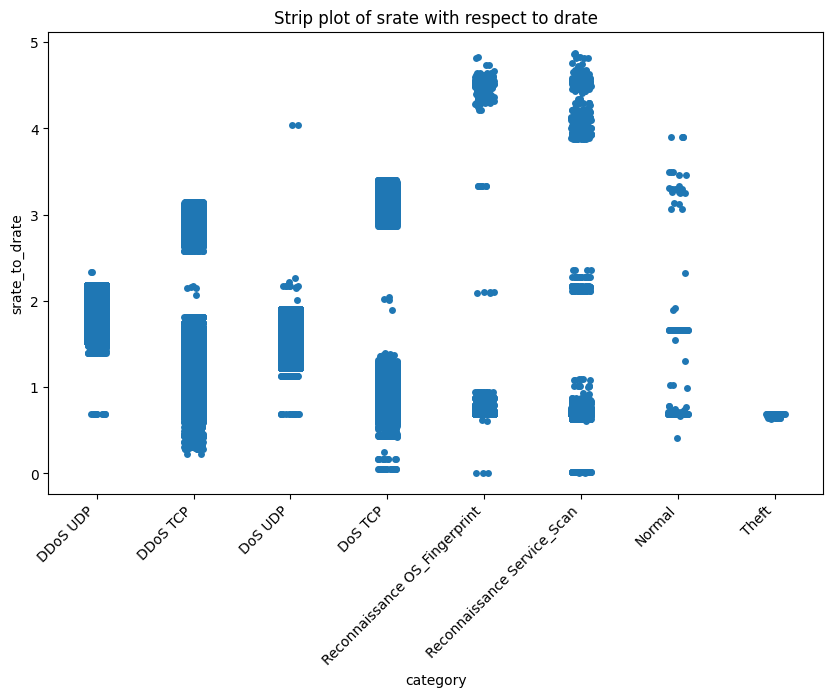

In [26]:
title = 'Strip plot of srate with respect to drate'
plt.figure(figsize=(10, 6))
plt.title(title)
sns.stripplot(data=training, x='category', y='srate_to_drate')
plt.xticks(rotation=45, ha='right')
plt.savefig(f'{FIGURES_PATH}/{title}.png')

This graph highlights very well how the `srate_to_drate` feature can be very useful in determing the category of attack, as for most of the cateogries, the values take very specific ranges, ignoring the outliers.

# Duration of Aggregated Records

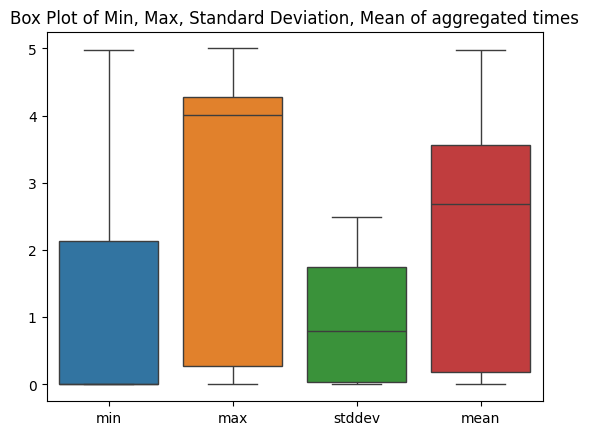

In [9]:
sns.boxplot(training_sample.loc[:, ['min', 'max', 'stddev', 'mean']])
title = 'Box Plot of Min, Max, Standard Deviation, Mean of aggregated times'
plt.title(title)
plt.savefig(f'{FIGURES_PATH}/{title}.png')

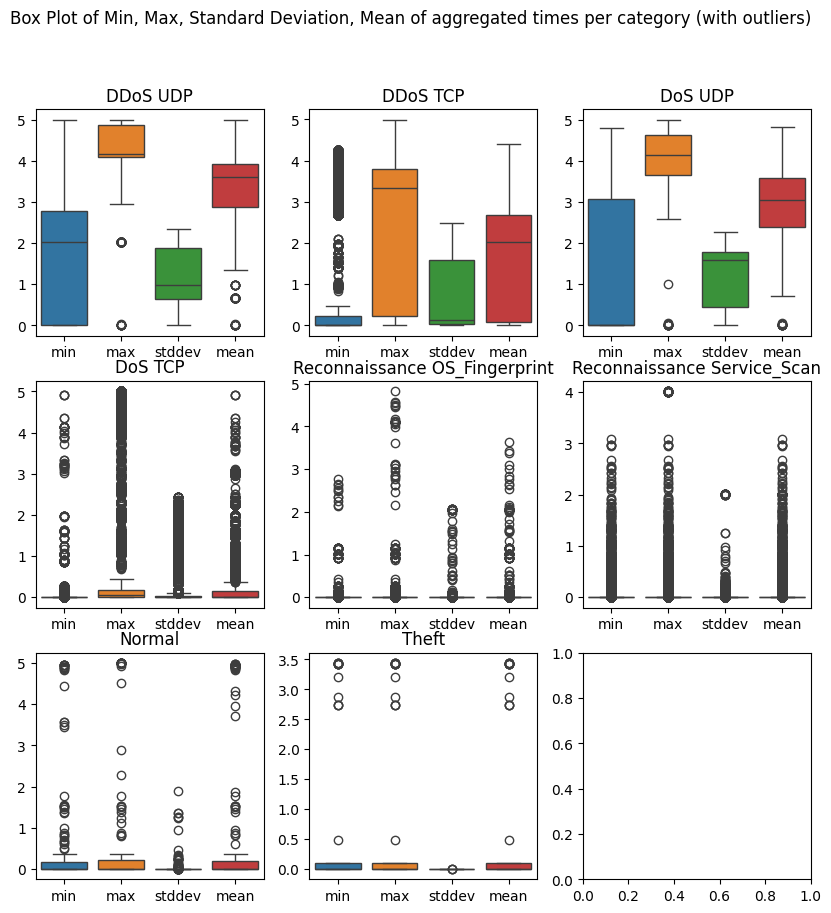

In [12]:
fig, axes = plt.subplots(3, 3)
title = 'Box Plot of Min, Max, Standard Deviation, Mean of aggregated times per category (with outliers)'
fig.suptitle(title)

categories = training['category'].unique()

for i in range(3):
  for j in range(3):
    if 3*i+j > 7:
      continue
    category = categories[3*i+j]
    category_data = training.loc[training['category'] == category, ['min', 'max', 'stddev', 'mean']]
    axes[i, j].set_title(category)
    sns.boxplot(data=category_data, ax=axes[i, j])

fig.set_size_inches(10, 10)
plt.savefig(f'{FIGURES_PATH}/{title}.png')

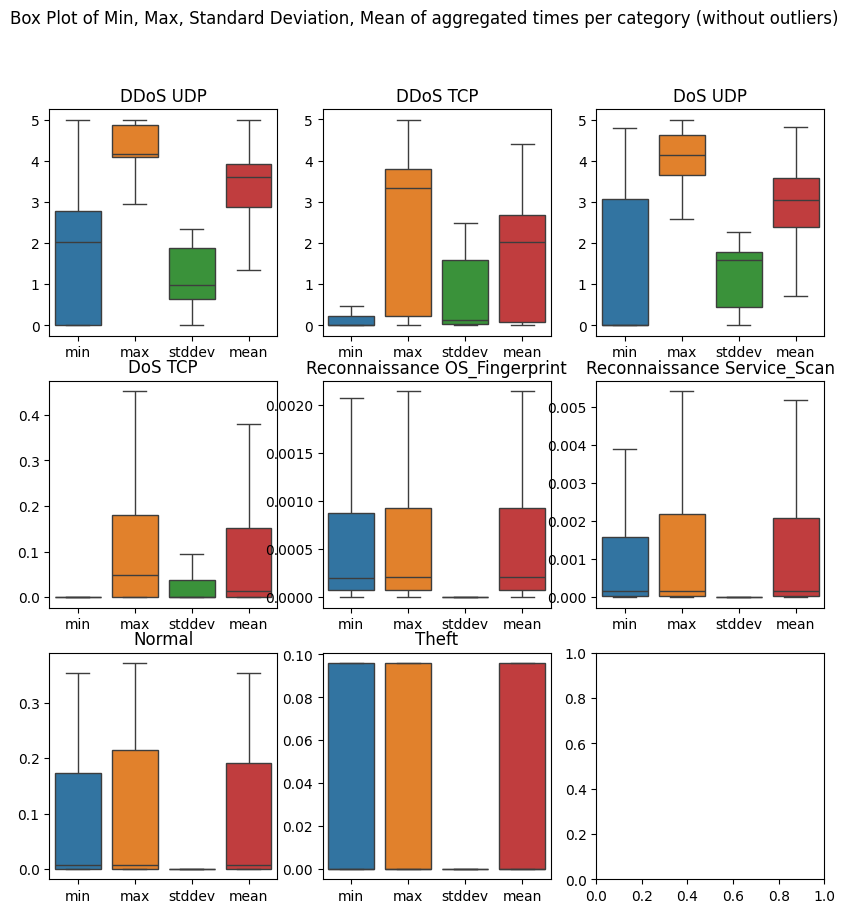

In [13]:
fig, axes = plt.subplots(3, 3)
title = 'Box Plot of Min, Max, Standard Deviation, Mean of aggregated times per category (without outliers)'
fig.suptitle(title)

categories = training['category'].unique()

for i in range(3):
  for j in range(3):
    if 3*i+j > 7:
      continue
    category = categories[3*i+j]
    category_data = training.loc[training['category'] == category, ['min', 'max', 'stddev', 'mean']]
    axes[i, j].set_title(category)
    sns.boxplot(data=category_data, ax=axes[i, j], showfliers=False)

fig.set_size_inches(10, 10)
plt.savefig(f'{FIGURES_PATH}/{title}.png')

### Box Plot Analysis: Aggregated Connection Times per Category (with outliers)

| Category                          | Min | Q1     | Median | Mean   | Q3     | Max  | StdDev | Key Characteristics |
|-----------------------------------|-----|--------|--------|--------|--------|------|--------|-----------------------|
| **Normal**                        | 0   | ~0.05  | ~0.10  | ~0.30  | ~0.50  | ~1.0 | Very Low  | Extremely fast & tight distribution, **many outliers** (long rare sessions) |
| **Theft**                         | 0   | ~0.05  | ~0.20  | ~0.80  | ~2.0   | ~3.5 | Moderate  | Low duration overall |
| **Reconnaissance – Service_Scan** | 0   | ~0.1   | ~0.8   | ~1.5   | ~2.5   | ~3.8 | High      | Moderate duration, **very high number of outliers** |
| **Reconnaissance – OS_Fingerprint**| 0  | ~0.1   | ~0.5   | ~1.2   | ~2.2   | ~4.5 | High      | Similar to Service_Scan, **lots of outliers** |
| **DoS TCP**                       | 0   | ~0.1   | ~0.3   | ~1.8   | ~3.8   | ~4.8 | Very High | Low median but **huge IQR & long tail** |
| **DoS UDP**                       | 0   | ~1.7   | ~2.8   | ~3.0   | ~3.5   | ~4.5 | Moderate  | Consistently higher duration |
| **DDoS TCP**                      | 0   | ~0.2   | ~1.5   | ~2.2   | ~3.2   | ~4.5 | Very High | Very high variability & heavy upper tail |
| **DDoS UDP**                      | 0   | ~1.8   | ~2.3   | ~2.5   | ~3.0   | ~4.8 | High      | High duration + many outliers |

### Key Findings (including your observations – confirmed correct)

- **Lowest connection durations** (fastest events):  
  **Normal > Theft > Reconnaissance categories > DoS TCP**  
  → generally exhibit the lowest durations.

- **Highest number of outliers**:  
  **Reconnaissance (both types) and Normal** traffic show an exceptionally large amount of outliers.  
  
- **Highest overall duration & variability**:  
  DoS UDP, DDoS UDP, and DDoS TCP are the slowest and most variable.

### Quick Ranking by Typical Duration
**Fastest → Slowest**  
Normal << Theft ≈ Reconnaissance ≈ DoS TCP < DDoS TCP < DDoS UDP ≈ DoS UDP

In summary: benign/recon/theft traffic is quick (but Recon & Normal have many unusually long sessions), while actual DoS/DDoS attacks take significantly longer and are far more inconsistent.